In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from textwrap import wrap

from copy import deepcopy

from jax import config
config.update("jax_debug_nans", True)

In [2]:
training_data = 'abcdefghijklmnopqrstuvwxyz'*2000

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'{len(training_data)} total characters')

26 unique characters
52000 total characters


In [3]:
hidden_size = 11

seq_length = 8

total_params = 5 * hidden_size * vocab_size + 4 * hidden_size**2 + 4 * hidden_size + vocab_size 

print(f'LSTM with {hidden_size} hidden units')
print(f'Single layer LSTM has {total_params} total parameters')
print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(txt)
print()

LSTM with 11 hidden units
Single layer LSTM has 1984 total parameters
Will train on character sequences of length 8

Training data sample: 

               abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqr               
               stuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghij               
                    klmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqr                    



In [4]:
def initialize_lstm_weights(key,n_h,n_x):
    
    subkeys=random.split(key,9)

    params = dict()

    params['Wxc'] = random.normal(subkeys[1],(n_h,n_x))*0.01 # input to cell state
    params['Wxu'] = random.normal(subkeys[2],(n_h,n_x))*0.01 # input to update
    params['Wxf'] = random.normal(subkeys[3],(n_h,n_x))*0.01 # input to forget
    params['Wxo'] = random.normal(subkeys[4],(n_h,n_x))*0.01 # input to output

    params['bc'] = jnp.zeros((n_h, 1)) # hidden bias
    params['bu'] = jnp.zeros((n_h, 1)) # forget bias
    params['bf'] = jnp.zeros((n_h, 1)) # update bias
    params['bo'] = jnp.zeros((n_h, 1)) # output bias

    params['Whc'] = random.normal(subkeys[5],(n_h,n_h))*0.01 # hidden to cell
    params['Whu'] = random.normal(subkeys[6],(n_h,n_h))*0.01 # hidden to update
    params['Whf'] = random.normal(subkeys[7],(n_h,n_h))*0.01 # hidden to forget
    params['Who'] = random.normal(subkeys[8],(n_h,n_h))*0.01 # hidden to output

    grad_mems = dict()
    sqrd_mems = dict()

    for parameter in params.keys():

        shape = params[parameter].shape

        grad_mems[parameter]=jnp.zeros(shape)
        sqrd_mems[parameter]=jnp.zeros(shape)

    return subkeys[0], params, grad_mems, sqrd_mems

def initialize_dense_weights(key,n_h,n_x):
    
    subkeys=random.split(key,2)

    params = dict()

    params['Why'] = random.normal(subkeys[1],(n_x,n_h))*0.01 # hidden to output
    params['by'] = jnp.zeros((n_x, 1)) # output bias

    grad_mems = dict()
    sqrd_mems = dict()

    for parameter in params.keys():

        shape = params[parameter].shape

        grad_mems[parameter]=jnp.zeros(shape)
        sqrd_mems[parameter]=jnp.zeros(shape)

    return subkeys[0], params, grad_mems, sqrd_mems

In [5]:
start_key = random.PRNGKey(0)

all_params, all_grads, all_sqrd = {},{},{}

key, all_params[0],all_grads[0],all_sqrd[0] = initialize_lstm_weights(start_key,hidden_size,vocab_size)

key, all_params[1],all_grads[1],all_sqrd[1] = initialize_lstm_weights(key,hidden_size,hidden_size)

key, all_params[2],all_grads[2],all_sqrd[2] = initialize_dense_weights(key,hidden_size,vocab_size)

print('Layer 0: ',all_params[0].keys())
print('Layer 1: ',all_params[1].keys())
print('Layer 2: ',all_params[2].keys())

total_params = 0

for k1,v1 in all_params.items():

    for k2,v2 in v1.items():

        print(k1,k2,v2.shape,v2.size)

        total_params += v2.size

print(total_params)

Layer 0:  dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'bc', 'bu', 'bf', 'bo', 'Whc', 'Whu', 'Whf', 'Who'])
Layer 1:  dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'bc', 'bu', 'bf', 'bo', 'Whc', 'Whu', 'Whf', 'Who'])
Layer 2:  dict_keys(['Why', 'by'])
0 Wxc (11, 26) 286
0 Wxu (11, 26) 286
0 Wxf (11, 26) 286
0 Wxo (11, 26) 286
0 bc (11, 1) 11
0 bu (11, 1) 11
0 bf (11, 1) 11
0 bo (11, 1) 11
0 Whc (11, 11) 121
0 Whu (11, 11) 121
0 Whf (11, 11) 121
0 Who (11, 11) 121
1 Wxc (11, 11) 121
1 Wxu (11, 11) 121
1 Wxf (11, 11) 121
1 Wxo (11, 11) 121
1 bc (11, 1) 11
1 bu (11, 1) 11
1 bf (11, 1) 11
1 bo (11, 1) 11
1 Whc (11, 11) 121
1 Whu (11, 11) 121
1 Whf (11, 11) 121
1 Who (11, 11) 121
2 Why (26, 11) 286
2 by (26, 1) 26
2996


In [6]:
def get_mini_batch(mini_batch_size,seq_length,char_to_ix,data):
    '''
    generator to continuous loop the data and pull out mini batches
    '''
    p = 0
    epoch = 0

    batch_character_size = mini_batch_size*(seq_length)

    while True:

        if p+batch_character_size+1>=len(data):
            p=0
            epoch = epoch + 1

            # need to reset hprev,cprev if it loops?

        inputs,targets = [],[]

        for _ in range(mini_batch_size):

            inputs.append([char_to_ix[ch] for ch in data[p:p+seq_length]])
            targets.append([char_to_ix[ch] for ch in data[p+1:p+seq_length+1]])

            p += seq_length

        inputs = jnp.array(inputs)
        targets = jnp.array(targets)

        yield inputs,targets,epoch

In [7]:
batch_gen = get_mini_batch(4,seq_length,char_to_ix,training_data)

inp,targ,epoch_test = next(batch_gen)

display(inp,targ,epoch_test)

print(f'm = {inp.shape[0]} seq_length = {inp.shape[1]}')

Array([[17, 12, 16, 19,  4, 10,  2,  7],
       [ 9, 25, 13, 18,  6,  3, 22,  0],
       [14, 20, 21, 15, 23, 11,  5, 24],
       [ 8,  1, 17, 12, 16, 19,  4, 10]], dtype=int32)

Array([[12, 16, 19,  4, 10,  2,  7,  9],
       [25, 13, 18,  6,  3, 22,  0, 14],
       [20, 21, 15, 23, 11,  5, 24,  8],
       [ 1, 17, 12, 16, 19,  4, 10,  2]], dtype=int32)

0

m = 4 seq_length = 8


In [8]:
def sigmoid(z):
    return 1.0/(1.0 + jnp.exp(-z))

def softmax(y):
    return jnp.exp(y) / jnp.sum(jnp.exp(y),axis=0)

def encode_inputs(inputs,vocab_size):
    '''
    inputs - batch of tokens (m,seq_length)

    vocab_size - needs to know number of characters in vocab to one-hot encode

    xs dictionary indexed by time t , each item has shape (n_x, m)

    '''

    xs = {}

    xs[-1] = None  # need hs and xs dicts to have same length = seq_length + 1

    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]
    
    for t in range(seq_length):
        xs[t] = jnp.zeros((vocab_size,mini_batch_size))
        xs[t] = xs[t].at[inputs[:,t],jnp.arange(mini_batch_size)].set(1) # batch of one-hot vectors for time t

    return xs



def lstm_forward(inputs,hprev,cprev,params):
    '''
    single forward pass of the LSTM

    returns loss for this mini-batch

    returns cache of variables needed for backwards pass
    '''

    # dims
    mini_batch_size = inputs[0].shape[1]
    seq_length = len(inputs) - 1
    #print("SEQ LENGTH ",seq_length)

    vocab_size = params['Wxc'].shape[1]

    # unpack params

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    #Why = params['Why']
    #by = params['by']

    # caches for forward pass

    #xs, hs, cs, c_tildes = {}, {}, {}, {}

    xs = inputs  # inputs should be given as dict with seq_length entries, each item = (n_x,m) array of vectors

    hs, cs, c_tildes = {},{},{}

    gamma_us, gamma_fs, gamma_os = {}, {}, {}

    hs[-1] = jnp.tile(hprev,(1,mini_batch_size))
    cs[-1] = jnp.tile(cprev,(1,mini_batch_size))

    for t in range(seq_length):
        #xs[t] = jnp.zeros((vocab_size,mini_batch_size))

        #xs[t] = xs[t].at[inputs[:,t],jnp.arange(mini_batch_size)].set(1) # batch of one-hot vectors for time t

        zc = jnp.dot(Wxc,xs[t]) + jnp.dot(Whc,hs[t-1]) + bc  # linear activation for candidate cell state C~
        zu = jnp.dot(Wxu,xs[t]) + jnp.dot(Whu,hs[t-1]) + bu  # linear activation for update gate
        zf = jnp.dot(Wxf,xs[t]) + jnp.dot(Whf,hs[t-1]) + bf  # linear activation for forget gate
        zo = jnp.dot(Wxo,xs[t]) + jnp.dot(Who,hs[t-1]) + bo  # linear activation for output gate

        c_tildes[t] = jnp.tanh(zc) # canidate for new c state

        gamma_us[t] = sigmoid(zu)
        gamma_fs[t] = sigmoid(zf)
        gamma_os[t] = sigmoid(zo)

        cs[t] = jnp.tanh(jnp.multiply(c_tildes[t],gamma_us[t]) + jnp.multiply(cs[t-1],gamma_fs[t]))  # tanh here is import!!!

        hs[t] = jnp.multiply(cs[t],gamma_os[t]) # hidden state

    gates = (gamma_us,gamma_fs,gamma_os)

    states = (xs,hs,cs,c_tildes)

    return states, gates

def loss_function(targets,hidden_states,Why,by):
    '''
    hidden_states - dict of LSTM activations from last LSTM layer
    '''

    mini_batch_size=targets.shape[0]
    seq_length = targets.shape[1]

    ys, ps = {},{}

    loss = 0

    for t in range(seq_length):

        ys[t] = jnp.dot(Why, hidden_states[t]) + by # unnormalized log probabilities for next chars

        ps[t] = softmax(ys[t]) # probabilities for next chars  #  ps[t] should be shape (vocab_size,mini_batch_size)

        loss += jnp.mean(jnp.log(jnp.sum(jnp.exp(ys[t]),axis=0)) - ys[t][targets[:,t],jnp.arange(mini_batch_size)])
        #loss += -jnp.mean(jnp.log(ps[t][targets[:,t],jnp.arange(mini_batch_size)]))

    p_cache = (ys,ps)

    return loss, p_cache

In [9]:

#initial zeros for hidden and cell states
h = jnp.zeros((hidden_size,1))
c = jnp.zeros((hidden_size,1))

#one-hot encode batch of input tokens
inputs_onehot = encode_inputs(inp,26)

print(len(inputs_onehot)-1,inputs_onehot[0].shape)

#dicts to hold lstm states and lstm gates each layer 
s_cache,g_cache = {},{}

#forward pass through first lstm layer 
s_cache[0], g_cache[0] = lstm_forward(inputs_onehot,h,c,all_params[0])

print(type(s_cache[0]),len(s_cache[0]),type(g_cache[0]),len(g_cache[0]))

hs_layer0 = s_cache[0][1]  # hidden states from layer zero

#forward pass through second lstm layer 
s_cache[1], g_cache[1] = lstm_forward(hs_layer0,h,c,all_params[1])

print(type(s_cache[0]),len(s_cache[0]),type(g_cache[0]),len(g_cache[0]))

hs_layer1 = s_cache[1][1]  # hidden states from layer 1

print(type(hs_layer1),len(hs_layer1))

# pass final hidden states to dense + softmax to get probs and loss 
test_loss,p_cache = loss_function(targ,hs_layer1,all_params[2]['Why'],all_params[2]['by'])



8 (26, 4)
<class 'tuple'> 4 <class 'tuple'> 3
<class 'tuple'> 4 <class 'tuple'> 3
<class 'dict'> 9


In [10]:
test_loss

Array(26.064774, dtype=float32)

In [11]:
print(type(p_cache),len(p_cache))
print(type(g_cache[0]),len(g_cache[0]))
print(type(s_cache[0]),len(s_cache[0]))

<class 'tuple'> 2
<class 'tuple'> 3
<class 'tuple'> 4


In [12]:
def loss_backward(targets,probs_cache,final_hidden_states,dense_params):

    #unpack caches

    ys,ps = probs_cache

    hs = final_hidden_states  # dictionary with hidden states from last layer

    #weights for dense output to softmax layer
    Why = dense_params['Why']
    by = dense_params['by']

    # dims
    mini_batch_size = targets.shape[0]  # targets = (m,seq_length) rows of tokens each sample
    seq_length = targets.shape[1]

    vocab_size = Why.shape[0]

    #initialize grads
    dWhy,dby = jnp.zeros_like(Why), jnp.zeros_like(by)

    #cache to pass gradients back to lstm_backwards
    dhs = {}

    #backward pass

    for t in reversed(range(seq_length)):
        dy = jnp.copy(ps[t])

        dy = dy.at[targets[:,t],jnp.arange(mini_batch_size)].add(-1) #backprop into y

        dWhy += jnp.dot(dy, hs[t].T)
        dby += jnp.sum(dy,axis=1,keepdims=True)

        dhs[t] = jnp.dot(Why.T, dy)

    grads = dict()

    grads['Why']=dWhy
    grads['by']=dby

    for parameter in grads.keys():
        grads[parameter] = jnp.clip(grads[parameter], -5, 5) # clip to mitigate exploding gradients

    return dhs, grads

def lstm_layer_backward(dh_next_layer,gates_cache,states_cache,params):
    '''
    backward pass of the LSTM

    return gradients for all parameters
    '''
    #unpack caches

    gamma_us,gamma_fs,gamma_os = gates_cache

    xs,hs,cs,c_tildes = states_cache

    # dh_next_layer # dictionary of derivatives from backpass of higher layer 

    # dims
    mini_batch_size = hs[-1].shape[1]  # note -1 is dict key for initilized h state , not last 
    seq_length = len(xs)-1 # make sure this works every layer ?

    vocab_size = params['Wxc'].shape[1]

    # unpack parameters

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    #initialize gradients to zero

    dWxc,dWxu,dWxf,dWxo = jnp.zeros_like(Wxc), jnp.zeros_like(Wxu), jnp.zeros_like(Wxf), jnp.zeros_like(Wxo)
    dWhc,dWhu,dWhf,dWho = jnp.zeros_like(Whc), jnp.zeros_like(Whu), jnp.zeros_like(Whf), jnp.zeros_like(Who)
    dbc,dbu,dbf,dbo = jnp.zeros_like(bc), jnp.zeros_like(bu), jnp.zeros_like(bf), jnp.zeros_like(bo)
    
    # tmp variables to accumulate gradients over the backprop -- see differentiation graph
    dhnext, dcnext = jnp.zeros_like(hs[0]), jnp.zeros_like(cs[0])

    #need dictionary to pass dh derivative each t to earlier layer

    dh_previous_layer = {}

    #backward pass

    for t in reversed(range(seq_length)):
        
        dh = dh_next_layer[t] + dhnext # backprop into h

        dc = jnp.multiply((1-cs[t]**2),jnp.multiply(gamma_os[t],dh) + dcnext) #backprop into c

        dcnext = jnp.multiply(gamma_fs[t],dc)

        dzc = jnp.multiply((1-c_tildes[t]**2),jnp.multiply(gamma_us[t],dc))  # backprop through tanh

        dzu = jnp.multiply(gamma_us[t]*(1-gamma_us[t]),jnp.multiply(c_tildes[t],dc))  # sigmoid prime

        dzf = jnp.multiply(gamma_fs[t]*(1-gamma_fs[t]),jnp.multiply(cs[t-1],dc))

        dzo = jnp.multiply(gamma_os[t]*(1-gamma_os[t]),jnp.multiply(cs[t],dh))

        dbc += jnp.sum(dzc,axis=1,keepdims=True)
        dbu += jnp.sum(dzu,axis=1,keepdims=True)
        dbf += jnp.sum(dzf,axis=1,keepdims=True)
        dbo += jnp.sum(dzo,axis=1,keepdims=True)

        dWhc += jnp.dot(dzc,hs[t-1].T)
        dWhu += jnp.dot(dzu,hs[t-1].T)
        dWhf += jnp.dot(dzf,hs[t-1].T)
        dWho += jnp.dot(dzo,hs[t-1].T)

        dWxc += jnp.dot(dzc,xs[t].T)
        dWxu += jnp.dot(dzu,xs[t].T)
        dWxf += jnp.dot(dzf,xs[t].T)
        dWxo += jnp.dot(dzo,xs[t].T)

        # four contributions to dhnext,one from each gate
        dhnext = jnp.dot(Whc.T,dzc) + jnp.dot(Whu.T,dzu) + jnp.dot(Whf.T,dzf) + jnp.dot(Who.T,dzo)

        dh_previous_layer[t] = jnp.dot(Wxc.T,dzc) + jnp.dot(Wxu.T,dzu) + jnp.dot(Wxf.T,dzf) + jnp.dot(Wxo.T,dzo)

    grads = dict()

    grads['Wxc']=dWxc
    grads['Wxu']=dWxu
    grads['Wxf']=dWxf
    grads['Wxo']=dWxo

    grads['Whc']=dWhc
    grads['Whu']=dWhu
    grads['Whf']=dWhf
    grads['Who']=dWho

    grads['bc']=dbc
    grads['bu']=dbu
    grads['bf']=dbf
    grads['bo']=dbo

    for parameter in grads.keys():
        grads[parameter] = jnp.clip(grads[parameter], -5, 5) # clip to mitigate exploding gradients

    return dh_previous_layer, grads

In [13]:
targ

Array([[12, 16, 19,  4, 10,  2,  7,  9],
       [25, 13, 18,  6,  3, 22,  0, 14],
       [20, 21, 15, 23, 11,  5, 24,  8],
       [ 1, 17, 12, 16, 19,  4, 10,  2]], dtype=int32)

In [14]:
type(s_cache[1][1])

dict

In [15]:
print(len(all_params))

3


In [16]:
# test the loss_backward function

dh_cache = {}

dh_cache[2], all_grads[2] = loss_backward(targ,p_cache,s_cache[1][1],all_params[2])

print(len(dh_cache[2]))
print(all_grads[2].keys())

8
dict_keys(['Why', 'by'])


In [17]:
#backprop lstm layer 1

dh_cache[1],all_grads[1] = lstm_layer_backward(dh_cache[2],g_cache[1],s_cache[1],all_params[1])

print(type(all_grads[1]),len(all_grads[1]))
print(all_grads[1].keys())

<class 'dict'> 12
dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'Whc', 'Whu', 'Whf', 'Who', 'bc', 'bu', 'bf', 'bo'])


In [18]:
#backprop lstm layer 2

dh_cache[0],all_grads[0] = lstm_layer_backward(dh_cache[1],g_cache[0],s_cache[0],all_params[0])

print(type(all_grads[0]),len(all_grads[0]))
print(all_grads[0].keys())

<class 'dict'> 12
dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'Whc', 'Whu', 'Whf', 'Who', 'bc', 'bu', 'bf', 'bo'])


In [19]:

def sgd_step_adam(current_step,inputs,targets,h_inputs,c_inputs,all_params,all_grads_mems,all_sqrd_mems,beta1,beta2,learning_rate):
    '''
    performs a single step of SGD optimization using the ADAM algorithm 

    current_step - count of SGD steps performed so far

    inputs (m,seq_length) - mini_batch arranged as rows of character tokens each seq_length long
    targets (m,seq_length) - inputs shifted right by 1

    h_inputs,c_inputs [dict] - dictionaries holding previus hidden/cell states for lstm layers numbered 0,1, ... num_layers-1

                                example: h_inputs[0] (hidden_size,1) - vector with hidden state to initialize lstm layer 0 

    all_params - dictionary holding params dictionaries for each layer 

                  all_params[0] - dictionary with 12 matrices for lstm layer 0 

                  all_params[num_layers] - dictionary with 2 matrices fof Why, by params of the output layer 

    all_grads_mems - copy of gradients computed last sgd step

    all_sqrd_mems  - copy of sqrd gradients from lst sgd step

    beta1,beta2,learning_rate - hyperparameters for ADAM optimization 
    '''

    # extract dimensions
    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]

    num_layers = len(all_params)-1  # this is number of lstm layers 

    vocab_size = all_params[0]['Wxc'].shape[1]

    n = current_step

    #one-hot encode the input batch

    layer_inputs = {}

    layer_inputs[0] = encode_inputs(inputs,vocab_size)

    s_cache_dict,g_cache_dict = {},{}

    dh_cache_dict = {}
    all_grads_dict = {} # holds gradients for parameters each layer 0,1,..num_layers-1 = LSTM and num_layers = dense 

    h_inputs_next = {} # need to pass final hidden states to next sgd_step
    c_inputs_next = {}

    #forwad pass
    for l in range(num_layers):

        h = h_inputs[l]
        c = c_inputs[l]

        x = layer_inputs[l]

        layer_params = all_params[l]

        s_cache_dict[l], g_cache_dict[l] = lstm_forward(x,h,c,layer_params)

        layer_inputs[l+1] = s_cache_dict[l][1]  # hidden states from this layer

        #h_inputs_next[l]=jnp.mean(layer_inputs[l+1][seq_length-1],axis=1,keepdims=True)
        #c_inputs_next[l]=jnp.mean(layer_inputs[l+1][seq_length-1],axis=1,keepdims=True)

        h_inputs_next[l]=jnp.expand_dims(layer_inputs[l+1][seq_length-1][:,-1],axis=1)
        c_inputs_next[l]=jnp.expand_dims(layer_inputs[l+1][seq_length-1][:,-1],axis=1)

    #compute loss
    loss,p_cache = loss_function(targets,layer_inputs[num_layers],all_params[num_layers]['Why'],all_params[num_layers]['by'])
  
    #loss backward 
    dh_cache_dict[num_layers], all_grads_dict[num_layers] = loss_backward(targets,p_cache,s_cache_dict[num_layers-1][1],all_params[num_layers])

    #lstm backwards
    for l in reversed(range(num_layers)):

        dh_cache_dict[l],all_grads_dict[l] = lstm_layer_backward(dh_cache_dict[l+1],g_cache_dict[l],s_cache_dict[l],all_params[l])

    new_all_params = deepcopy(all_params)
    new_all_grads_mems = deepcopy(all_grads_mems)
    new_all_sqrd_mems = deepcopy(all_sqrd_mems)

    #ADAM for all layers

    #loop throuh lstm layers = 0,1,...num_layers-1

    # dense layer = num_layers

    for l in range(num_layers+1):

        # perform parameter update with ADAM 
        for parameter in new_all_params[l].keys():

            dparam = all_grads_dict[l][parameter] / mini_batch_size

            new_all_grads_mems[l][parameter] = beta1*new_all_grads_mems[l][parameter] + (1-beta1)*dparam

            new_all_sqrd_mems[l][parameter] = beta2*new_all_sqrd_mems[l][parameter] + (1-beta2)*dparam*dparam

            grad_hat = new_all_grads_mems[l][parameter] / (1-beta1**(n+1))
            sqrd_hat = new_all_sqrd_mems[l][parameter] / (1-beta2**(n+1))

            new_all_params[l][parameter] += -learning_rate * grad_hat / (jnp.sqrt(sqrd_hat + 1e-8)) # ADAM update

    params_cache = (new_all_params,new_all_grads_mems,new_all_sqrd_mems)

    hidden_cache = (h_inputs_next,c_inputs_next)
    
    return loss, params_cache, hidden_cache

#jit the function, hope it runs Fast !!! 
sgd_step_adam_jit = jit(sgd_step_adam)

In [20]:
print(len(all_params),len(all_grads),len(all_sqrd))

num_layers = len(all_params)-1

h_inp = {}
c_inp = {}

for l in range(num_layers):
    h_inp[l] = jnp.zeros((hidden_size,1))
    c_inp[l] = jnp.zeros((hidden_size,1))

print(len(h_inp),len(c_inp))

test_loss, test_params_cache,test_hidden_cache = sgd_step_adam_jit(
                                                                    current_step=0,
                                                                    inputs=inp,
                                                                    targets=targ,
                                                                    h_inputs=h_inp,
                                                                    c_inputs=c_inp,
                                                                    all_params=all_params,
                                                                    all_grads_mems=all_grads,
                                                                    all_sqrd_mems=all_sqrd,
                                                                    beta1=0.9,
                                                                    beta2=0.99,
                                                                    learning_rate=0.01)

3 3 3
2 2


In [21]:
test_loss

Array(26.064774, dtype=float32)

In [22]:
def sample(seed_ix,n,key,h_inputs,c_inputs,all_params,temperature=1.0):

    num_layers = len(all_params)-1

    vocab_size = all_params[0]['Wxc'].shape[1]

    #unpack params for output layer
    Why = all_params[num_layers]['Why']
    by = all_params[num_layers]['by']

    x = jnp.zeros((vocab_size, 1))
    x = x.at[seed_ix].set(1)

    layer_inputs = {}

    layer_inputs[0] = x

    xs_layers = {}
    hs_layers = {}
    cs_layers = {}

    for t in range(n+1):
        xs_layers[t]={}
        hs_layers[t]={}
        cs_layers[t]={}

    hs_layers[0]=h_inputs
    cs_layers[0]=c_inputs

    xs_layers[0][0] = x

    ixes = [seed_ix]
    for t in range(n):

        for l in range(num_layers):
            
            h = hs_layers[t][l]
            c = cs_layers[t][l]

            x = xs_layers[t][l]

            Wxc = all_params[l]['Wxc']
            Wxu = all_params[l]['Wxu']
            Wxf = all_params[l]['Wxf']
            Wxo = all_params[l]['Wxo']

            Whc = all_params[l]['Whc']
            Whu = all_params[l]['Whu']
            Whf = all_params[l]['Whf']
            Who = all_params[l]['Who']

            bc = all_params[l]['bc']
            bu = all_params[l]['bu']
            bf = all_params[l]['bf']
            bo = all_params[l]['bo']    

            zc = jnp.dot(Wxc,x) + jnp.dot(Whc,h) + bc  # linear activation for candidate cell state C~
            zu = jnp.dot(Wxu,x) + jnp.dot(Whu,h) + bu  # linear activation for update gate
            zf = jnp.dot(Wxf,x) + jnp.dot(Whf,h) + bf  # linear activation for forget gate
            zo = jnp.dot(Wxo,x) + jnp.dot(Who,h) + bo  # linear activation for output gate

            c_tilde = jnp.tanh(zc)

            gamma_u = sigmoid(zu)
            gamma_f = sigmoid(zf)
            gamma_o = sigmoid(zo)

            cs_layers[t+1][l] = jnp.tanh(jnp.multiply(c_tilde,gamma_u) + jnp.multiply(c,gamma_f))

            hs_layers[t+1][l] = jnp.multiply(cs_layers[t+1][l],gamma_o) # hidden state

            xs_layers[t][l+1] = hs_layers[t+1][l]

        y = jnp.dot(Why,xs_layers[t][l+1]) + by

        p = softmax(y/temperature)

        key,subkey = random.split(key)  #use key to split, subkey for next random number

        ix = random.choice(subkey,vocab_size,p=p.reshape(-1,))

        x_new = jnp.zeros((vocab_size, 1))
        x_new = x_new.at[ix].set(1)

        #ixes.append(int(ix))
        ixes.append(int(ix))

        xs_layers[t+1][0] = x_new

    return ixes    

def validation_loss(inputs,targets,h_inputs,c_inputs,all_params):

    num_layers = len(all_params)-1

    vocab_size = all_params[0]['Wxc'].shape[1]

    layer_inputs={}

    layer_inputs[0] = encode_inputs(inputs,vocab_size)

    for l in range(num_layers):

        h = h_inputs[l]
        c = c_inputs[l]

        x = layer_inputs[l]

        layer_params = all_params[l]

        s_cache, _ = lstm_forward(x,h,c,layer_params)

        layer_inputs[l+1]=s_cache[1] #hidden outputs this layer

    val_loss,val_p_cache = loss_function(targets,layer_inputs[num_layers],all_params[num_layers]['Why'],all_params[num_layers]['by'])

    return val_loss

validation_loss_jit = jit(validation_loss)

In [23]:
h_inp = {}
c_inp = {}

for l in range(num_layers):
    h_inp[l] = jnp.zeros((hidden_size,1))
    c_inp[l] = jnp.zeros((hidden_size,1))

test_val_loss = validation_loss_jit(inp,targ,h_inp,c_inp,all_params)

print(test_val_loss)

26.064774


In [26]:

def train_character_lstm(seq_length,hidden_sizes,mini_batch_size,learning_rate,total_steps,steps_sample_freq,initial_key,training_data,validation_data=None):
    '''
    fingers crossed!
    '''

    #unique characters in the data set
    chars = set(list(training_data))
    vocab_size = len(chars)

    #character encoding
    char_to_ix = {ch:i for i,ch in enumerate(chars)}
    ix_to_char = {i:ch for i,ch in enumerate(chars)}

    # initialize data generators
    training_generator = get_mini_batch(mini_batch_size,seq_length,char_to_ix,training_data)
    if validation_data:
       validation_generator = get_mini_batch(mini_batch_size,seq_length,char_to_ix,validation_data)

    #current training step counter
    n = 0

    num_layers = len(hidden_sizes)   # number of lstm layers 

    #initialize the model weight matrices

    all_params = {}
    all_grads = {}
    all_sqrd = {}

    h_inputs,c_inputs = {},{}

    for l in range(num_layers):

        if l==0:
           prev_layer_size = vocab_size
        elif l>0:
           prev_layer_size = hidden_sizes[l-1]

        key, all_params[l],all_grads[l],all_sqrd[l] = initialize_lstm_weights(initial_key,hidden_sizes[l],prev_layer_size)

        h_inputs[l] = jnp.zeros((hidden_sizes[l],1))
        c_inputs[l] = jnp.zeros((hidden_sizes[l],1))

    key, all_params[num_layers],all_grads[num_layers],all_sqrd[num_layers] = initialize_dense_weights(key,hidden_sizes[num_layers-1],vocab_size)

    total_params = 0

    for k1,v1 in all_params.items():
        layer_total = 0
        for k2,v2 in v1.items():
            layer_total += v2.size
            print(k1,k2,v2.shape)

        total_params += layer_total
        print(f'Layer {k1}: {layer_total} parameters')

    print(f'LSTM Model has {num_layers+1} layers with {total_params} parameters')

    #keep list of loss each training step
    
    step_list = [0]

    tau = len(training_data) / (mini_batch_size * seq_length)

    alpha = jnp.exp(-4./tau).item()

    print(f'tau: {tau} alpha: {alpha}')

    smooth_loss = -jnp.log(1.0/vocab_size)*seq_length

    train_losses,smooth_losses,val_losses = [smooth_loss],[smooth_loss],[smooth_loss]

    last_epoch = 0

    sample_size = 200

    sample_ix = [0]*sample_size

    while n < total_steps:
          
          inputs,targets,current_epoch = next(training_generator)

          if current_epoch > last_epoch:

             last_epoch = current_epoch
             
             for l in range(num_layers):
                 h_inputs[l] = jnp.zeros((hidden_sizes[l],1))
                 c_inputs[l] = jnp.zeros((hidden_sizes[l],1))
          
          current_loss, params_cache, hidden_cache = sgd_step_adam_jit(
                                                                current_step=n,
                                                                inputs=inputs,
                                                                targets=targets,
                                                                h_inputs=h_inputs,
                                                                c_inputs=c_inputs,
                                                                all_params=all_params,
                                                                all_grads_mems=all_grads,
                                                                all_sqrd_mems=all_sqrd,
                                                                beta1=0.9,
                                                                beta2=0.999,
                                                                learning_rate=learning_rate)   
          
          smooth_loss = alpha*smooth_loss + (1-alpha)*current_loss

          # need to unpack caches so they are passed to next step
          h_inputs,c_inputs = hidden_cache
          all_params,all_grads,all_sqrd=params_cache

          # sample from the model now and then
          if n % steps_sample_freq == 0:
             key,subkey=random.split(key) #key to split, subkey to gen next random sample

             sample_ix = sample(sample_ix[-1],sample_size,subkey,h_inputs,c_inputs,all_params)

             txt = ''.join(ix_to_char[int(ix)] for ix in sample_ix)
             txt_wrap = wrap(txt,80)
             txt_wrap = [line.center(100) for line in txt_wrap]
             txt = '\n'.join(txt_wrap)  # \n aren't in the character set so wrap text to make readable

             print('----\n %s \n----' % (txt,))

             print(f'Step n: {n}\t Epoch: {current_epoch}')

             print(f'Train Current: {current_loss:.4f}\tTrain Smoothed: {smooth_loss:.4f}')

             step_list.append(n)
             train_losses.append(current_loss)
             smooth_losses.append(smooth_loss)

             #compute_validation_loss
             if validation_generator:
                inputs_val,targets_val,val_epoch = next(validation_generator)

                val_loss = validation_loss_jit(inputs_val,targets_val,h_inputs,c_inputs,all_params)

                print(f'Val Current: {val_loss:.4f}') 

                val_losses.append(val_loss)       

          n+=1

    history = (step_list,smooth_losses,train_losses,val_losses)

    return history, params_cache, hidden_cache

In [27]:
mykey = random.PRNGKey(1)

seq_length = 10

hidden_sizes = [32]

mini_batch_size = 16

train_data = training_data
val_data = training_data[513:]

history,out_params,out_hidden = train_character_lstm(                  
                                  seq_length=seq_length,
                                  hidden_sizes=hidden_sizes,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=1000,
                                  steps_sample_freq=250,
                                  initial_key=mykey,
                                  training_data=train_data,
                                  validation_data=val_data)                

0 Wxc (32, 26)
0 Wxu (32, 26)
0 Wxf (32, 26)
0 Wxo (32, 26)
0 bc (32, 1)
0 bu (32, 1)
0 bf (32, 1)
0 bo (32, 1)
0 Whc (32, 32)
0 Whu (32, 32)
0 Whf (32, 32)
0 Who (32, 32)
Layer 0: 7552 parameters
1 Why (26, 32)
1 by (26, 1)
Layer 1: 858 parameters
LSTM Model has 2 layers with 8410 parameters
tau: 325.0 alpha: 0.98776775598526
----
           pmzfphamdxasnjbnhbfjiejetaknogubqsssbpwxkzycbuhwgqrufptgbsfxtuxasjltiuzontedbxcb          
          ykxtsmgerbnlixvgvdhwjqxatpbvzwwabrakadnspntsudzniqaiofbuutukosrvrpcfexgqleuporwx          
                             pkzcndyjuerdwngdfqkvylcqsisnlyqotclhoarmx                               
----
Step n: 0	 Epoch: 0
Train Current: 32.5806	Train Smoothed: 32.5810
Val Current: 32.5674
----
           xyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxy          
          zabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyza          
                             bcdefghijklmnopqrstuvwxyzabcdef

In [28]:
import matplotlib.pyplot as plt

import numpy as np

def plot_training_history(history,mini_batch_size,seq_length,training_length,plot_smooth=False,plot_val=True):

    step_list,smooth_losses,train_losses,val_losses = history

    fig,ax = plt.subplots(figsize=(10,6))

    t_list = np.array(step_list)

    t_list = t_list * mini_batch_size * seq_length / training_length

    train_log_loss = np.log10(np.array(train_losses))

    if plot_smooth:
       smooth_log_loss = np.log10(np.array(smooth_losses))
       ax.plot(t_list,smooth_log_loss,'bo-')

    ax.plot(t_list,train_log_loss,'go-')

    if len(val_losses)==len(step_list) and plot_val:
       val_log_loss = np.log10(np.array(val_losses))

       ax.plot(t_list,val_log_loss,'ro-')

    ax.set_ylabel('$Log_{10}(L)$')
    ax.set_xlabel('Epochs')

    plt.show()

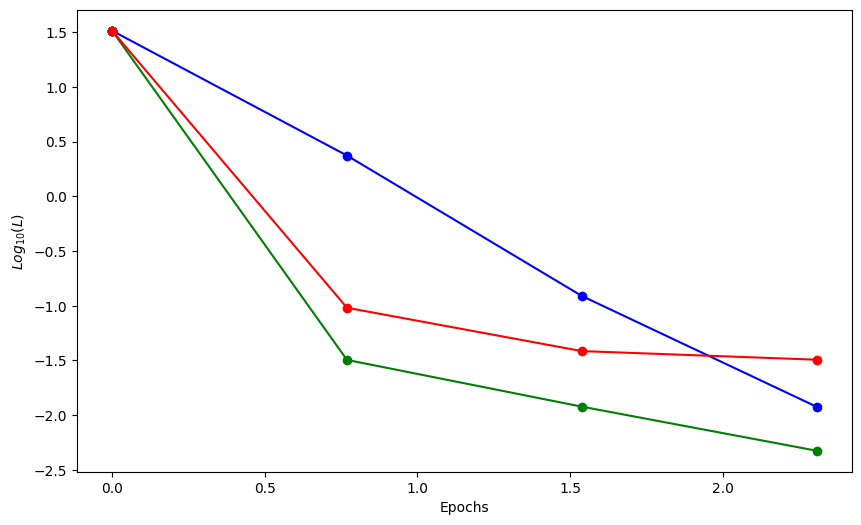

In [29]:
plot_training_history(history,
                      mini_batch_size,
                      seq_length,
                      len(training_data),
                      plot_smooth=True,
                      plot_val=True)

In [30]:
import re

with open('illiad_clean.txt','r') as file:
  text_data = file.read()

text_data = re.sub(r"\[.\]"," ",text_data)

text_data = re.sub(r"[^a-zA-Z0-9.,?!:;“”'`’ ]+", " ", text_data)

text_data = re.sub(r"[\s]+"," ",text_data)

train_split = 0.85
n_train = int(len(text_data)*train_split)

training_data = text_data[:n_train]
validation_data = text_data[n_train:]

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'Training has {len(training_data)} total characters')
print(f'Validation has {len(validation_data)} total characters')

seq_length = 100

print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(txt)
print()

73 unique characters
Training has 740442 total characters
Validation has 130667 total characters
Will train on character sequences of length 100

Training data sample: 

               ide, At once a virgin, and at once a bride! No more with presents her                
               embraces meet, Or lay the spoils of conquest at her feet, On whom his                
                    passion, lavish of his store, Bestow’d so much, and vainly p                    



0 Wxc (64, 73)
0 Wxu (64, 73)
0 Wxf (64, 73)
0 Wxo (64, 73)
0 bc (64, 1)
0 bu (64, 1)
0 bf (64, 1)
0 bo (64, 1)
0 Whc (64, 64)
0 Whu (64, 64)
0 Whf (64, 64)
0 Who (64, 64)
Layer 0: 35328 parameters
1 Wxc (64, 64)
1 Wxu (64, 64)
1 Wxf (64, 64)
1 Wxo (64, 64)
1 bc (64, 1)
1 bu (64, 1)
1 bf (64, 1)
1 bo (64, 1)
1 Whc (64, 64)
1 Whu (64, 64)
1 Whf (64, 64)
1 Who (64, 64)
Layer 1: 33024 parameters
2 Why (73, 64)
2 by (73, 1)
Layer 2: 4745 parameters
LSTM Model has 3 layers with 73097 parameters
tau: 115.6940625 alpha: 0.966016948223114
----
                   A:DyOZ :ox Mg’vV4kC0WRXFJ QVEgSbt,MMbKHjtPmdf5ZngB85YAJ'vMy.aUj                   
          ,X;3“SDM93RovjlvGQjJM:DFuv1shxf'f64n0BxL3KbIP7H v8LQ2ogTAg3,UNOgWtlWUYv.SJUqU,?i          
                     uAlCR.zasRUOMuHxOQDlgo”0SRuNH1'NycqImslcMW,g2GBMJr24E28:.                       
----
Step n: 0	 Epoch: 0
Train Current: 429.0464	Train Smoothed: 429.0460
Val Current: 426.4463
----
              . The merloang, prordse the drith nith

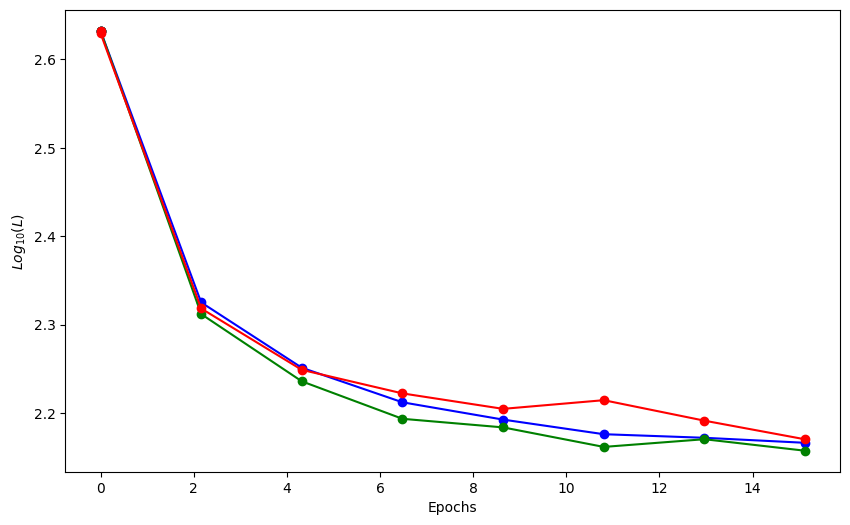

In [31]:
mykey = random.PRNGKey(1)

seq_length = 100

hidden_sizes = [64,64]

mini_batch_size = 64

history,out_params,out_hidden = train_character_lstm(                  
                                  seq_length=seq_length,
                                  hidden_sizes=hidden_sizes,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.02,
                                  total_steps=2000,
                                  steps_sample_freq=250,
                                  initial_key=mykey,
                                  training_data=training_data,
                                  validation_data=validation_data)

plot_training_history(history,
                      mini_batch_size,
                      seq_length,
                      len(training_data),
                      plot_smooth=True,
                      plot_val=True)

In [33]:
key = random.PRNGKey(7)

sample_size = 2000

key,subkey=random.split(key) #use key to get next key, subkey for random number

h_zeros_start = {l:jnp.zeros_like(out_hidden[0][l]) for l in range(2)}
c_zeros_start = {l:jnp.zeros_like(out_hidden[1][l]) for l in range(2)}

sample_ix = sample(char_to_ix['T'],sample_size,subkey,h_zeros_start,c_zeros_start,out_params[0],temperature=0.6)

txt = ''.join(ix_to_char[ix] for ix in sample_ix)
txt_wrap = wrap(txt,80)
txt_wrap = [line.center(100) for line in txt_wrap]
txt = '\n'.join(txt_wrap)  # \n aren't in the character set so wrap text to make readable

print('----\n %s \n----' % (txt,))

----
           T. the day’d: Unjust the soul give the sounds the spoke imperon sat that charge           
           the solred, or shall free the generous friends the skies, In the plain, While            
          the loud son Their fear, The son of battle steeds the gold, High at leaders o’er          
           the stand the prince the spear the words from but the brief the son; The plain           
           the chiefs of the ground, The sacred string the steeds his guide the generous            
           way, Hector, and the steeds the soul the field, She standing o’er the land the           
           glory stronger host. The skill with the fields. The call’d his sorrows beneath           
            the field of said. So stands, and rage the sudden of where the sounding the             
             sands of the word bear the fight; The field: The seat I bends the part the             
            martial parting as the deed the sent his warrior deed the heavenly prove 